In [1]:
import numpy as np
from math import pi, sqrt
from scipy.special import erf
import matplotlib.pyplot as plt

In [2]:
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

In [34]:
## Constants ##
# Paticle:
mx = 100                            # GeV
vo = 230e5 * 3600 * 24              # cm/day
beta = vo / (3e5 * 1e5 * 3600 * 24) # units of c
# Nucleus:
A = 40
M = 931.5e-3 * A                    # GeV
# Kinematics:
theta = np.linspace(0, pi, num=500) # rad
vesc = 600e5 * 3600 * 24            # cm/day
# Form Factor:
s = 0.9                             # fm
c = 1.23*A**(1/3) - 0.6             # fm
a = 0.52                            # fm
hc = 197.3e-3                       # GeV fm
# Event rate for vE = 0:
No = 6.022e26 / A                   # 1/kg
rho = 0.3                           # GeV/cm3
sigma = 1e-45                       # cm2

In [19]:
def kinematics(mx, M):
    mr = (mx * M) / (mx + M)       # GeV
    mrn = (mx * M/A) / (mx + M/A)  # GeV
    r = 4*mr**2 / (mx*M)
    Eo = 0.5 * mx * beta**2        # GeV
    ER = 0.5 * Eo * r * (1 - np.cos(theta))
    q = np.sqrt(2 * M * ER)        # GeV
    output = {'mr': mr,
             'mrn': mrn,
              'r': r,
              'Eo': Eo,
             'q': q,
             'ER': ER}
    return output

In [35]:
def form_factor(dic_kinematics):
    q = dic_kinematics['q']
    rn = np.sqrt(c**2 + 7/3 * pi**2 * a**2 - 5*s**2) #fm
    arg_norm = q*rn/hc
    j1 = (np.sin(arg_norm) - arg_norm * np.cos(arg_norm)) / arg_norm**2
    FF = 3 * j1 * np.exp(-0.5*(q*s/hc)**2) /arg_norm
    return FF

In [21]:
def compute_Ro(dic_kinematics):
    mr = dic_kinematics['mr']
    mrn = dic_kinematics['mrn']
    Ro = 2/sqrt(pi) * No*rho/mx * (mr/mrn)**2 * A * sigma * vo # events /kgday
    return Ro

In [22]:
def factors_of_dR(dic_kinematics):
    r = dic_kinematics['r']
    Eo = dic_kinematics['Eo']
    ER = dic_kinematics['ER']
    t = np.linspace(0, 365, num=366)
    vmin = np.sqrt(ER / (Eo*r)) * vo                                              # cm/day
    vE = np.max(232 + 15*np.cos( (t - 152.5)/365.25 )) * 1e5 * 3600 * 24          # cm/day
    k0_k1 = ( erf(vesc/vo) - 2/sqrt(pi)*vesc/vo * np.exp(-(vesc/vo)**2) )**(-1)
    output = {'vmin': vmin,
             'vE': vE,
             'k0_k1': k0_k1}
    return output

In [42]:
def compute_dRdER(dic_kinematics, FF, Ro, factors_of_dR):
    r = dic_kinematics['r']
    Eo = dic_kinematics['Eo']
    vmin = factors_of_dR['vmin']
    vE = factors_of_dR['vE']
    k0_k1 = factors_of_dR['k0_k1']
    output = k0_k1 * Ro/(Eo*r) * ( sqrt(pi)*vo/(4*vE)*( erf((vmin+vE)/vo) - erf((vmin-vE)/vo) ) - 
                                  np.exp(-(vesc/vo)**2) ) * FF**2 * 1e-6 # events/keVkgday
    return output

In [43]:
def Differential_Recoil_Spectrum(mx, M):
    dic_kinematics = kinematics(mx, M)
    FF = form_factor(dic_kinematics)
    Ro = compute_Ro(dic_kinematics)
    dR_factors = factors_of_dR(dic_kinematics)
    dRdER = compute_dRdER(dic_kinematics, FF, Ro, dR_factors)
    return dRdER, dic_kinematics['ER']

In [44]:
dRdER, ER = Differential_Recoil_Spectrum(mx, M)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


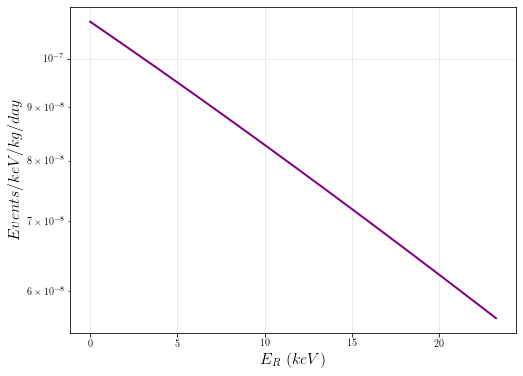

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.plot(ER*1e6, dRdER, 'purple', lw=2)
plt.xlabel('$E_R\ (keV)$', fontsize=16)
plt.ylabel('$Events / keV / kg / day$', fontsize=16)
#plt.xlim([0, 30])
plt.yscale('log')
plt.grid(alpha=.3)
plt.show()